# Overview
This notebook provides the ability to generate random droplet parameters, write them to disk, and 
train a neural network with said droplet parameters to approximate the underlying ODEs that govern 
the droplet parameters.  Once trained researchers can generate a Fortran 90 module that provides 
the ability to estimate droplet radius and temperature for some time in the future.  

The intent is that a small, reasonably trained neural network can provide accurate enough droplet 
characteristic estimations that are significantly faster than an iterative Gauss-Newton technique.
Initial testing indicates a small 4-layer network (roughly 2400 parameters) with Fortran 90 module
generated by this notebook is 30-90x faster than the existing (as of 2024/09/25) iterative approach 
which results in roughly a factor of 2x overall simulation speedup.

This notebook is broken down into the following sections:

1. ODEs of interest
2. Mapping data to/from $[-1, 1]$
3. Generating random droplets
4. Training a neural network
5. Analyzing a network's performance
6. Exporting a network to Fortran 90



In [10]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn


from droplet_approximation.physics import scale_droplet_parameters
from droplet_approximation.analysis import analyze_model_iterative_performance, mse_score_models
from droplet_approximation.models import *
from droplet_approximation.models import do_iterative_inference, generate_fortran_module




In [ ]:
model_load_paths = ["../models/network_400m.pth",
                    "../models/network_400m_weighted.pth",
                    "../models/network_400m_jagged.pth",
                    "../models/network_400m_jagged_weighted.pth",
                    "../models/large_dataset_narrow_jagged.pth"]

testing_data_file = "../data/testing_data.data"


In [2]:
model_count = len(model_load_paths)

model_names = [path.split( "/" )[-1].split( "." )[0] for path in model_load_paths]

models = [SimpleNet() for i in range(model_count)]

for i in range(model_count):
    models[i].load_state_dict( torch.load(model_load_paths[i]))

Inputs: [3.2243383e-07 2.7952634e+02 2.2159757e-18 2.9171490e+02 1.0677983e+00
 9.9512303e-01]
Inputs: [3.2243383e-07 2.7952634e+02 2.2159757e-18 2.9171490e+02 1.0677983e+00
 9.9512303e-01]
Inputs: [3.2243383e-07 2.7952634e+02 2.2159757e-18 2.9171490e+02 1.0677983e+00
 9.9512303e-01]
Inputs: [3.2243383e-07 2.7952634e+02 2.2159757e-18 2.9171490e+02 1.0677983e+00
 9.9512303e-01]
Inputs: [3.2243383e-07 2.7952634e+02 2.2159757e-18 2.9171490e+02 1.0677983e+00
 9.9512303e-01]


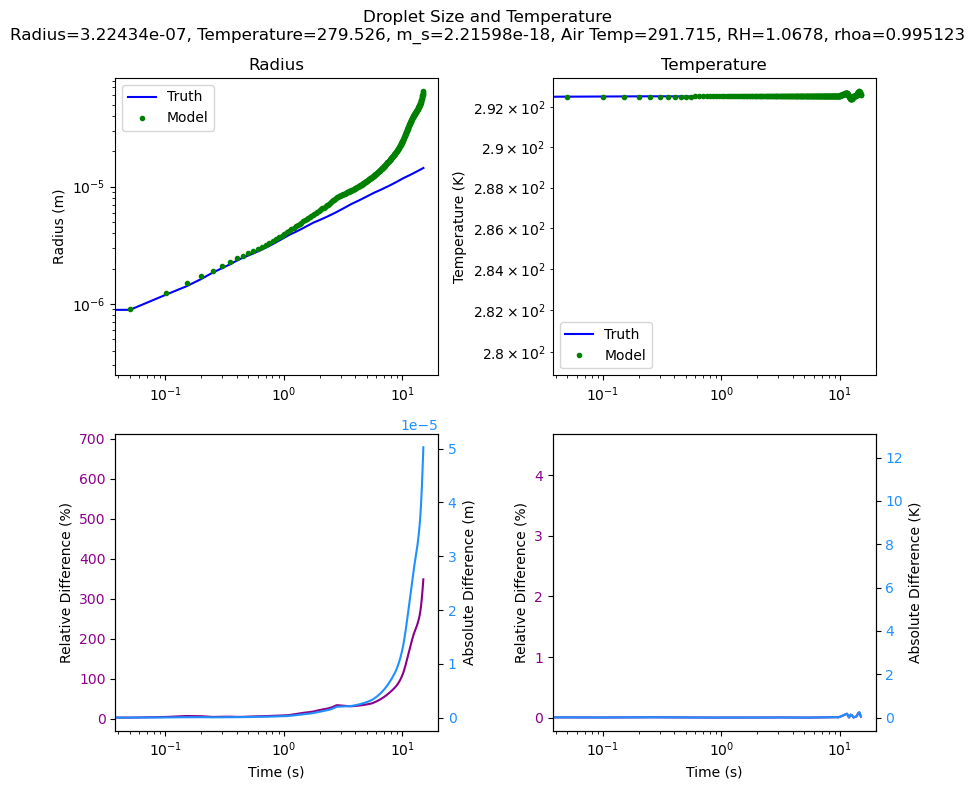

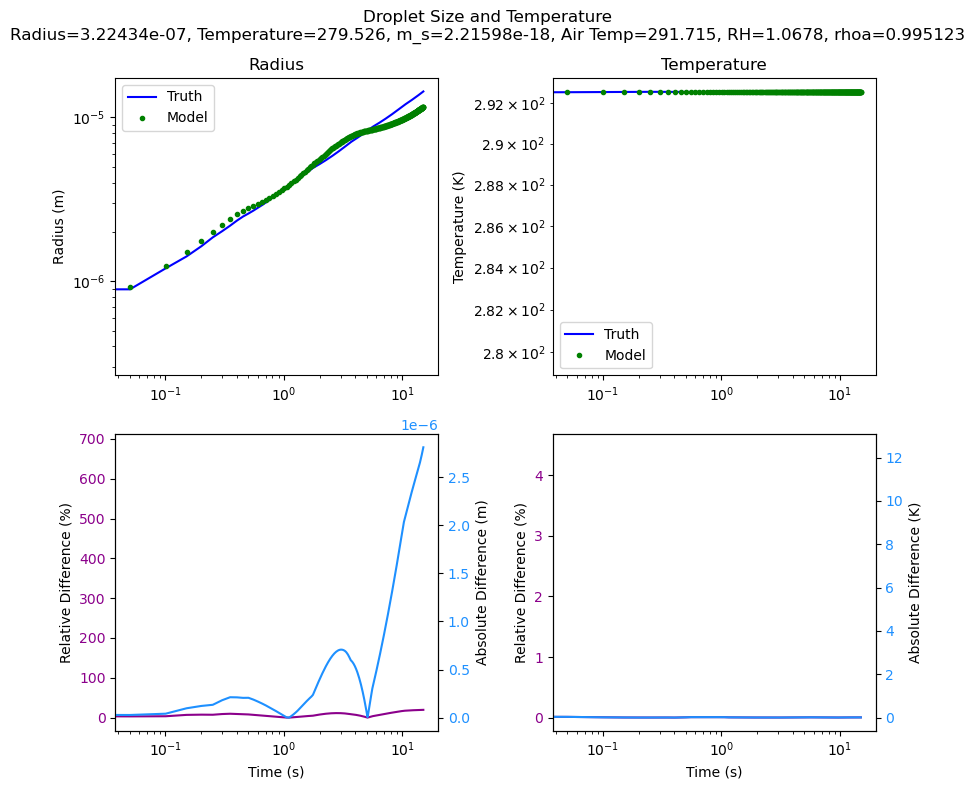

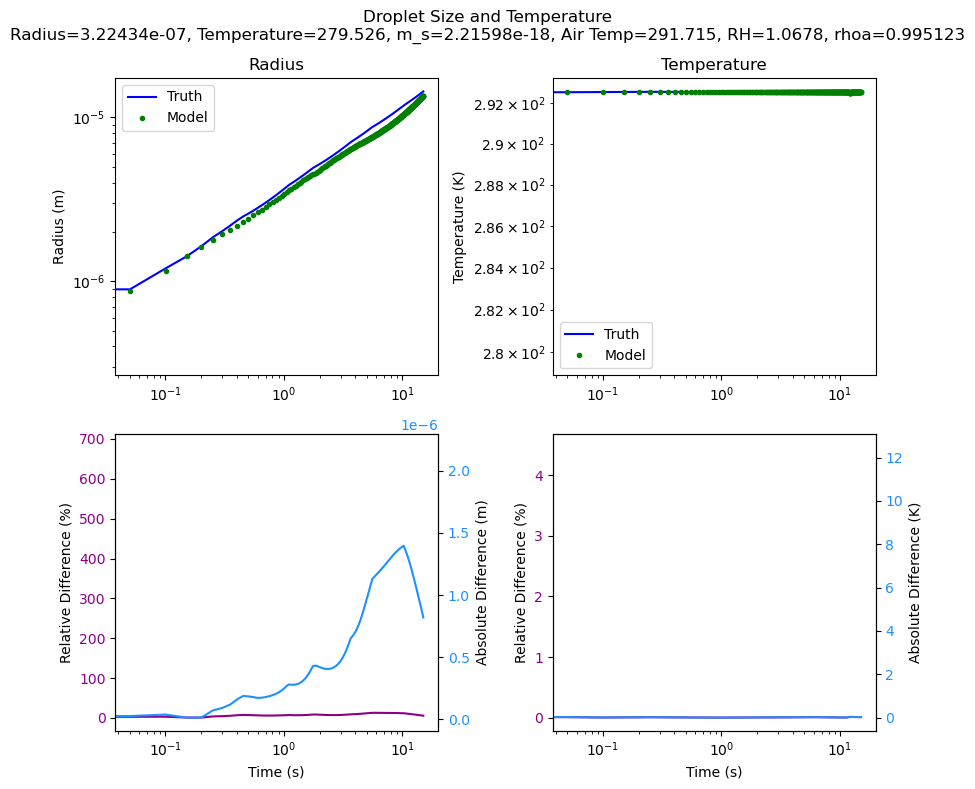

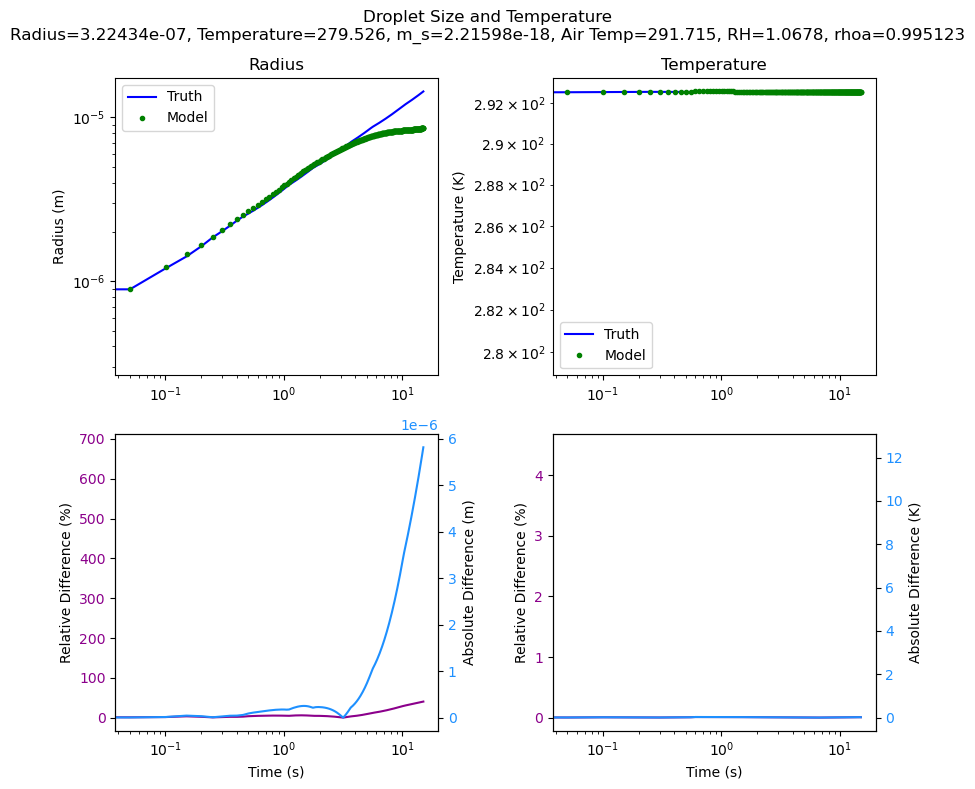

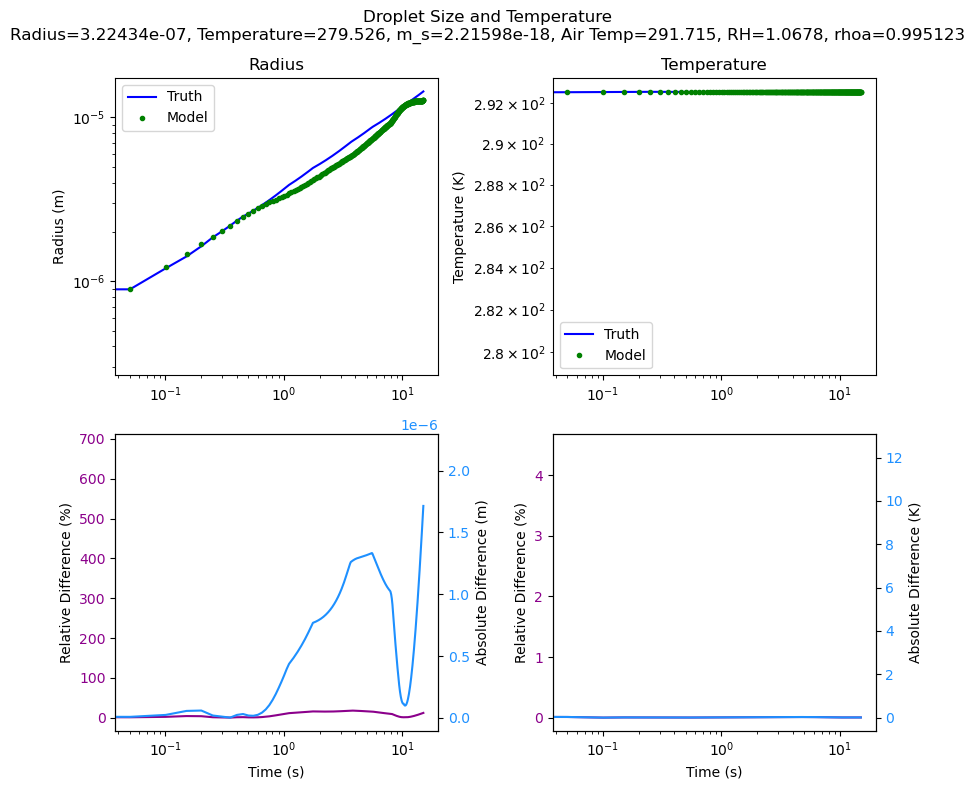

In [9]:

graph_count = 1
dt = 0.05
final_time = 15.0

for i in range(graph_count):
    input_parameters = scale_droplet_parameters(np.array( np.random.uniform( low = -1.0, high = 1.0, size=(1,6)).astype( "float32" )))[0]
    for j in range(model_count):
        analyze_model_iterative_performance(models[j], input_parameters, dt, final_time=final_time)

In [4]:
losses = mse_score_models(models,testing_data_file, "cpu")
rankings = np.argsort(losses)

print("Models sorted best to worst:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

[[7.48719406 7.48719406]
 [0.63513017 0.63513017]
 [0.24792576 0.24792576]
 ...
 [1.40453587 1.40453587]
 [0.15305574 0.15305574]
 [0.11012268 0.11012268]]
[[7.4771028e-06 2.9273715e+02]
 [1.1427635e-05 3.0094882e+02]
 [1.5141212e-07 2.9956329e+02]
 ...
 [9.2448630e-07 2.9038306e+02]
 [1.3633892e-06 2.9079947e+02]
 [2.9035298e-06 3.0286908e+02]]
Models sorted best to worst:

Loss for network_400m_weighted:  0.010210113525390625
Loss for network_400m:  0.011007287693023681
Loss for network_400m_jagged_weighted:  0.011735770988464355
Loss for large_dataset_narrow_jagged:  0.013495372676849365
Loss for network_400m_jagged:  0.014196097278594971


In [ ]:

losses = mse_score_models(models,testing_data_file, "cpu", True)
rankings = np.argsort(losses)

print("Models sorted best to worst MSE:\n")
for i in range(model_count):
    print("Loss for " + model_names[rankings[i]] + ": ", losses[rankings[i]])

[[7.48719406 7.48719406]
 [0.63513017 0.63513017]
 [0.24792576 0.24792576]
 ...
 [1.40453587 1.40453587]
 [0.15305574 0.15305574]
 [0.11012268 0.11012268]]
[[7.4771028e-06 2.9273715e+02]
 [1.1427635e-05 3.0094882e+02]
 [1.5141212e-07 2.9956329e+02]
 ...
 [9.2448630e-07 2.9038306e+02]
 [1.3633892e-06 2.9079947e+02]
 [2.9035298e-06 3.0286908e+02]]
Models sorted best to worst:

Loss for network_400m_weighted:  0.06254239499524196
Loss for network_400m_jagged_weighted:  0.10203303630676472
Loss for network_400m:  0.13651887062346874
Loss for large_dataset_narrow_jagged:  0.24929919716041532
Loss for network_400m_jagged:  0.26478684017625703


In [15]:
generate_fortran_module(model_names[rankings[0]], models[rankings[0]].state_dict(), "../models/droplet_model.f90")